# Data Visualization

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.neighbors
import sklearn.ensemble
import sklearn.cluster
import matplotlib.pyplot as plt
import ast
import gensim, logging
import xgboost
import lightgbm
import datetime

C:\Users\caioj\Anaconda3\envs\forest-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
read_train_df = pd.read_csv('data/train.csv')
read_test_df = pd.read_csv('data/evaluation.csv')
read_train_df.describe()

,retweets_count,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,TweetID
count,353969.000000,353969.000000,3.539690e+05,3.539690e+05,353969.000000,353969.000000,3.539690e+05,3.539690e+05
mean,15.831810,46.655442,2.021548e+04,4.808507e+04,1459.289003,0.030005,1.647004e+12,6.872503e+05
std,241.986723,852.044385,2.598715e+05,1.133854e+05,2502.933271,0.170602,4.846468e+09,4.175793e+05
min,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,1.301178e+12,3.000000e+00
25%,0.000000,0.000000,1.600000e+02,2.972000e+03,214.000000,0.000000,1.647068e+12,3.194490e+05
50%,1.000000,0.000000,7.260000e+02,1.250100e+04,693.000000,0.000000,1.647292e+12,6.719730e+05
75%,3.000000,1.000000,2.283000e+03,4.352200e+04,1804.000000,0.000000,1.647532e+12,1.049644e+06
max,63674.000000,122591.000000,1.441710e+07,8.183508e+06,237269.000000,1.000000,1.647727e+12,1.434456e+06


In [3]:
read_train_df

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049
...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,[],1647438153000,142573
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,[],1647072106000,240866
353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,[],1647607230000,1173763
353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,[],1646987195000,929182


In [29]:
read_train_df['mentions'].apply(ast.literal_eval).apply(len).describe()

count    353969.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: mentions, dtype: float64

In [ ]:
read_train_df.urls = read_train_df.urls.apply(ast.literal_eval)
read_train_df.hashtags = read_train_df.hashtags.apply(ast.literal_eval)

In [10]:
temp = read_train_df.explode('urls')[['urls', 'favorites_count']]
avg_per_url = temp.groupby(['urls']).mean().to_dict()['favorites_count']

temp = read_train_df.explode('hashtags')[['hashtags', 'favorites_count']]
avg_per_hashtag = temp.groupby(['hashtags']).mean().to_dict()['favorites_count']

In [17]:
def format_df(df: pd.DataFrame,
                  type: str = 'train',
                  keep_time: bool = False,
                  keep_fts: bool = False):
    final_df = df.drop(['TweetID', 'mentions', 'timestamp'], axis=1)

    if keep_fts:
        def apply_avg_urls(list_obj):
            result = 0.0
            for url in list_obj:
                result += avg_per_url[url] if url in avg_per_url else 0.0
            return result / len(list_obj) if list_obj else 0.0
        url_avg_favs = df['urls'].apply(apply_avg_urls).rename('fav_avg_per_url')
        final_df = pd.concat([final_df, url_avg_favs], axis=1)

        def apply_max_hashtags(list_obj):
            result = 0.0
            for hashtag in list_obj:
                result += avg_per_hashtag[hashtag] if hashtag in avg_per_hashtag else 0.0
            return result / len(list_obj) if list_obj else 0.0
        hash_avg_favs = df['hashtags'].apply(apply_max_hashtags).rename('fav_avg_per_hashtag')
        final_df = pd.concat([final_df, hash_avg_favs], axis=1)

        text_len = df['text'].apply(len).rename('text_len')
        final_df = pd.concat([final_df, text_len], axis=1)

    final_df.urls = final_df.urls.apply(len)
    final_df.hashtags = final_df.hashtags.apply(len)

    if keep_time:
        timestamps = df.timestamp // 1000
        timestamps = timestamps.apply(datetime.datetime.fromtimestamp).apply(datetime.datetime.timetuple)

        time_df = pd.DataFrame(timestamps.tolist(), index=df.index,
                               columns=['tm_year', 'tm_mon', 'tm_mday', 'tm_hour', 'tm_min', 'tm_sec', 'tm_wday',
                                        'tm_yday', 'tm_isdst'])
        time_df = time_df.drop(['tm_year', 'tm_mon', 'tm_mday', 'tm_isdst'], axis=1)

        final_df = pd.concat([final_df, time_df], axis=1)

    return final_df

In [18]:
train_df = format_df(read_train_df, keep_time=True, keep_fts=True)

In [19]:
train_df

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,urls,verified,hashtags,fav_avg_per_url,fav_avg_per_hashtag,text_len,tm_hour,tm_min,tm_sec,tm_wday,tm_yday
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,0,0,0,0.0,0.0,34,6,54,8,4,70
1,populaire,0,0,86,1016,284,0,0,0,0.0,0.0,9,13,51,28,5,78
2,faut dégager cinglé,3,1,1944,28234,1995,0,0,0,0.0,0.0,19,19,47,28,1,74
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,1,0,0,0.0,0.0,123,12,11,22,0,73
4,mafieuse oppressive macron,0,0,13957,25311,10841,0,0,0,0.0,0.0,26,12,46,14,0,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,1,0,0,0.0,0.0,30,14,42,33,2,75
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,0,0,0,0.0,0.0,69,9,1,46,5,71
353966,eric zemmour français berbère,3,0,1888,712,3086,0,0,0,0.0,0.0,29,13,40,30,4,77
353967,gauchistes dépression pq,0,0,139,486,320,0,0,0,0.0,0.0,24,9,26,35,4,70


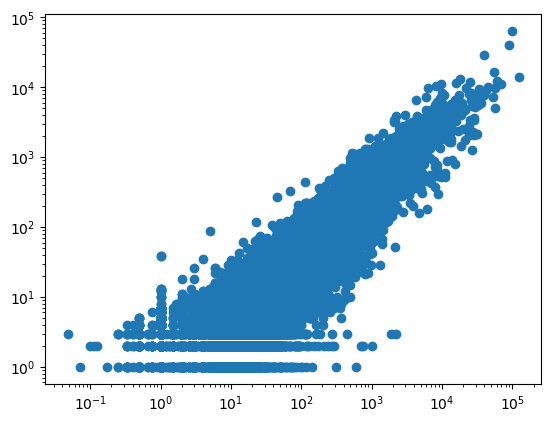

In [24]:
plt.scatter(train_df['fav_avg_per_url'], train_df['retweets_count'])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [ ]:
new_train_df[new_train_df['retweets_count'] > 10000]['text']

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(new_train_df['retweets_count'], new_train_df['favorites_count'])
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

In [ ]:
train_df_input = new_train_df.drop(['retweets_count', 'text'], axis=1)
train_df_input

In [ ]:
cluster_cols = train_df_input[['favorites_count', 'followers_count', 'statuses_count', 'friends_count']].values
normalized = (cluster_cols - cluster_cols.mean(0)) / cluster_cols.std(0)

clustering = sklearn.cluster.BisectingKMeans()
clustering.fit(normalized)

In [ ]:
print('  mean   |   std    |   min   |   max   |   len')
for i in range(clustering.n_clusters):
    print('%.2f' % new_train_df[clustering.labels_ == i]['retweets_count'].mean(),
          '    |    ',
          '%.2f' % new_train_df[clustering.labels_ == i]['retweets_count'].std(),
          '    |    ',
          '%.2f' % new_train_df[clustering.labels_ == i]['retweets_count'].min(),
          '    |    ',
          '%.2f' % new_train_df[clustering.labels_ == i]['retweets_count'].max(),
          '    |    ',
          new_train_df[clustering.labels_ == i]['retweets_count'].shape[0]
          )

In [ ]:
train_df['urls'] = train_df['urls'].apply(ast.literal_eval)

In [ ]:
url_set = set()

def add_to_set(set_obj):
    for obj in set_obj:
        url_set.add(obj)

train_df['urls'].apply(add_to_set)

In [ ]:
temp = train_df.explode('urls')[['urls', 'retweets_count']]
avg_per_url = temp.groupby(['urls']).mean().to_dict()['retweets_count']

In [ ]:
def apply_avg_urls(list_obj):
    sum = 0
    for url in list_obj:
        sum += avg_per_url[url]
    return sum / len(list_obj) if len(list_obj) > 0 else 0.0

train_df['urls'].apply(apply_avg_urls)

In [ ]:
train_df['text'].apply(len)

In [ ]:
plt.stem(new_train_df[new_train_df['retweets_count'] > 0]['retweets_count'])
plt.show()

In [ ]:
new_test_df = format_df(test_df, type='test', url_len_only=True, hashtag_len_only=True)
test_df_input = new_test_df.drop(['text'], axis=1)
test_df_input

In [ ]:
input_with_gts = pd.concat([train_df['retweets_count'], train_df_input], axis=1)

num_fts = input_with_gts.shape[1]
corr = np.corrcoef(input_with_gts.values.T)

fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(corr, cmap='bwr')
ax.set_xticks(np.arange(num_fts), labels=input_with_gts.columns)
ax.set_yticks(np.arange(num_fts), labels=input_with_gts.columns)
plt.colorbar(im)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(num_fts):
    for j in range(num_fts):
        text = ax.text(j, i, '%.2f' % corr[i, j], ha="center", va="center", color="k")
fig.tight_layout()
plt.show()

# NLP

In [ ]:
nlp_model = gensim.models.Word2Vec.load('models/word2vec.model')

train_tweets = new_train_df['text'].apply(str.split).to_list()
train_dictionary = gensim.corpora.Dictionary(train_tweets)
train_corpus = [train_dictionary.doc2bow(tweet) for tweet in train_tweets]

tfidf = gensim.models.TfidfModel(train_corpus)

In [ ]:
text = train_df['text'].iloc[3].split(' ')
text_vecs = nlp_model.wv[text]
text_img = text_vecs.T @ text_vecs


print(text)
plt.imshow(text_img)
plt.show()

In [ ]:
text = new_train_df['text']
i = 0
encoded_words = [word for word in text.iloc[i].split(' ') if word in nlp_model.wv and
                 word in train_dictionary.token2id]
if encoded_words:
    keys = [train_dictionary.token2id[word] for word in encoded_words]
    tf_idf_dict = dict(tfidf[train_corpus[i]])
    tf_idf_coefs = np.array([tf_idf_dict[key] for key in keys])

    text_vec = nlp_model.wv[encoded_words]
    text_vec = (text_vec * tf_idf_coefs[:, None]).sum(0)

text_vec

# Trees, Boosting

In [ ]:
full_train_X = train_df_input.values
full_train_X = (full_train_X - train_df_input.values.mean(0)) / train_df_input.values.std(0)

full_train_y = train_df['retweets_count'].values

full_test_X = (test_df_input.values - train_df_input.values.mean(0)) / train_df_input.values.std(0)

use_text = False

if use_text:
    train_text = train_df['text']
    test_text = test_df['text']

    new_train_X = np.zeros((full_train_X.shape[0], full_train_X.shape[1] + nlp_model.vector_size))
    new_test_X = np.zeros((full_train_X.shape[0], full_train_X.shape[1] + nlp_model.vector_size))

    for i in range(len(full_train_X)):
        text_vec = nlp_model.wv[train_text.iloc[i].split(' ')].mean(0)
        new_train_X[i] = np.concatenate([full_train_X[i], text_vec])

    for i in range(len(full_test_X)):
        encoded_words = [word for word in test_text.iloc[i].split(' ') if word in nlp_model.wv]
        if encoded_words:
            text_vec = nlp_model.wv[encoded_words].mean(0)
            new_test_X[i] = np.concatenate([full_test_X[i], text_vec])
        else:
            new_test_X[i] = np.concatenate([full_test_X[i], np.zeros((nlp_model.vector_size,))])

    full_train_X = new_train_X
    full_test_X = new_test_X

In [ ]:
perform_cv = False

if perform_cv:
    scores_xgboost = sklearn.model_selection.cross_validate(xgboost.XGBRegressor(verbosity=0,
                                                                                 max_depth=10),
                                                            full_train_X,
                                                            full_train_y,
                                                            cv=5,
                                                            scoring='neg_mean_absolute_error',
                                                            verbose=2)

    print(- scores_xgboost['test_score'].mean())

# Make submission

In [ ]:
make_submission = False

if make_submission:
    test_ids = test_df[['TweetID']]
    model = xgboost.XGBRegressor(verbosity=2)
    model.fit(full_train_X, full_train_y)

    test_predictions = model.predict(full_test_X)

    submission_df = pd.DataFrame(data={'retweets_count': test_predictions})
    submission_df = pd.concat([test_ids, submission_df], axis=1)
    submission_df.to_csv('data/submission.csv', index=False)